In [7]:
import pandas as pd
import numpy as np
import hashlib
import networkx as nx
from collections import Counter, deque
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
import joblib
import random as rd
import seaborn as sns

In [3]:
graphs, labels = joblib.load("../../dataset/streamspot/graphs_and_labels_streamspot.joblib")

In [4]:
class FlexSketch:
    def __init__(self, max_bins=100, max_histograms=5):
        self.max_bins = max_bins
        self.max_histograms = max_histograms
        self.histograms = deque()
        self.weights = deque()

    def update(self, label_counter):
        most_common = label_counter.most_common(self.max_bins)
        vector = np.zeros(self.max_bins)
        for i, (_, count) in enumerate(most_common):
            vector[i] = count
        self.histograms.append(vector)
        self.weights.append(1.0)
        if len(self.histograms) > self.max_histograms:
            self.histograms.popleft()
            self.weights.popleft()
        total_weight = sum(self.weights)
        self.weights = deque([w / total_weight for w in self.weights])

    def estimate_vector(self):
        result = np.zeros(self.max_bins)
        for h, w in zip(self.histograms, self.weights):
            result += w * h
        return result

# WL subtree extraction
def wl_subtree_features(graph, k=2):
    node_labels = nx.get_node_attributes(graph, 'label')
    features = {node: [node_labels.get(node, 'N/A')] for node in graph.nodes()}
    current_labels = node_labels.copy()
    for _ in range(k):
        new_labels = {}
        for node in graph.nodes():
            neighbors = sorted(
                [str(current_labels.get(nbr, '')) for nbr in graph.predecessors(node)] +
                [str(current_labels.get(nbr, '')) for nbr in graph.successors(node)]
            )
            combined = str(current_labels.get(node, '')) + "|" + "|".join(neighbors)
            hash_label = hashlib.md5(combined.encode()).hexdigest()
            new_labels[node] = hash_label
            features[node].append(hash_label)
        current_labels = new_labels
    return features

In [5]:
print("Extracting FlexSketch vectors...")
flex_vectors = []
for G in tqdm(graphs, desc="Vectorizing"):
    wl_feats = wl_subtree_features(G, k=3)
    all_labels = []
    for lbls in wl_feats.values():
        all_labels.extend(lbls)
    sketch = FlexSketch(max_bins=100)
    sketch.update(Counter(all_labels))
    flex_vectors.append(sketch.estimate_vector())



Extracting FlexSketch vectors...


Vectorizing: 100%|██████████| 600/600 [00:31<00:00, 19.01it/s]


Splitting benign and attack samples...
Standardizing feature vectors...
Training KMeans on benign samples...
Computing anomaly threshold...


Benign distances: 100%|██████████| 500/500 [00:00<00:00, 117791.06it/s]


Predicting anomalies...


Predicting: 100%|██████████| 550/550 [00:00<00:00, 113784.51it/s]

Evaluating...


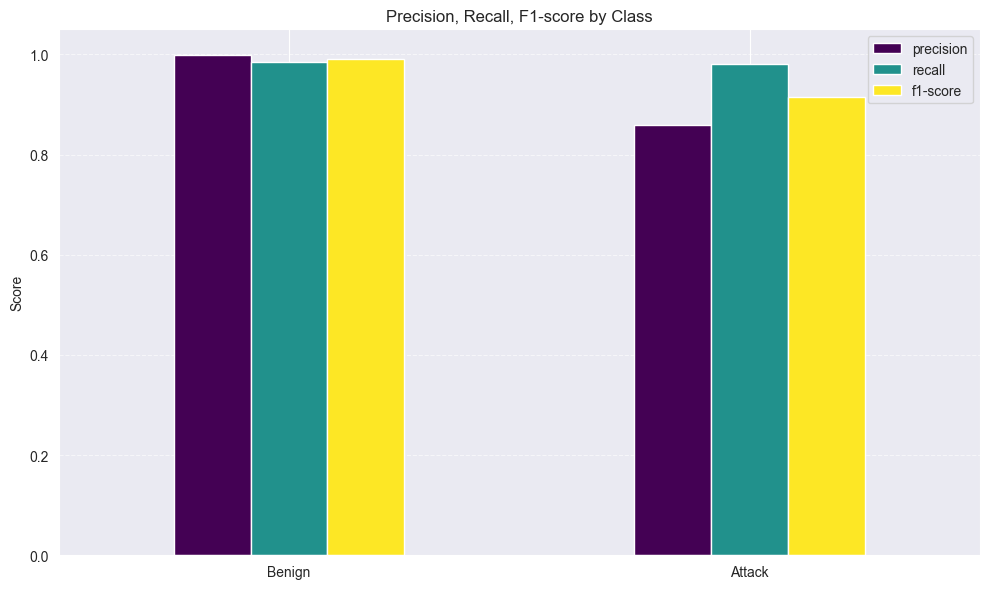

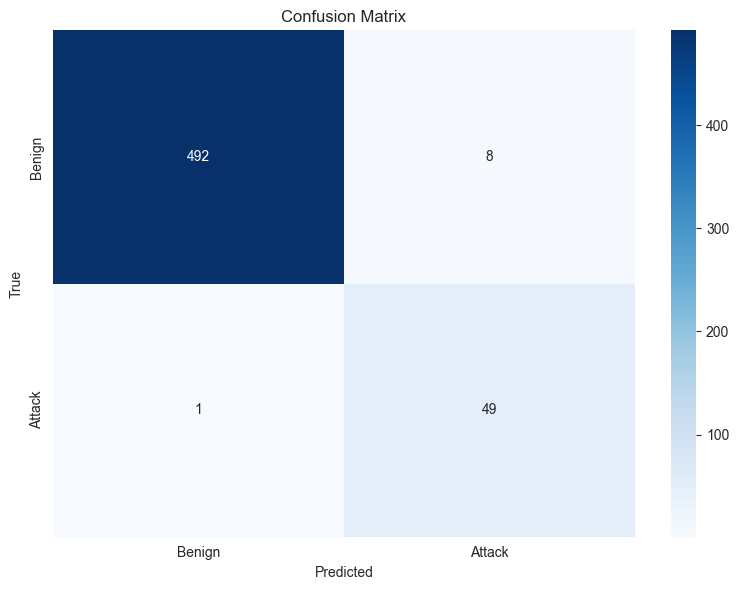


=== Classification Report (Anomaly Detection) ===
{'Benign': {'precision': 0.9979716024340771, 'recall': 0.984, 'f1-score': 0.9909365558912386, 'support': 500.0}, 'Attack': {'precision': 0.8596491228070176, 'recall': 0.98, 'f1-score': 0.9158878504672897, 'support': 50.0}, 'accuracy': 0.9836363636363636, 'macro avg': {'precision': 0.9288103626205473, 'recall': 0.982, 'f1-score': 0.9534122031792642, 'support': 550.0}, 'weighted avg': {'precision': 0.9853968315588899, 'recall': 0.9836363636363636, 'f1-score': 0.9841139463072434, 'support': 550.0}}


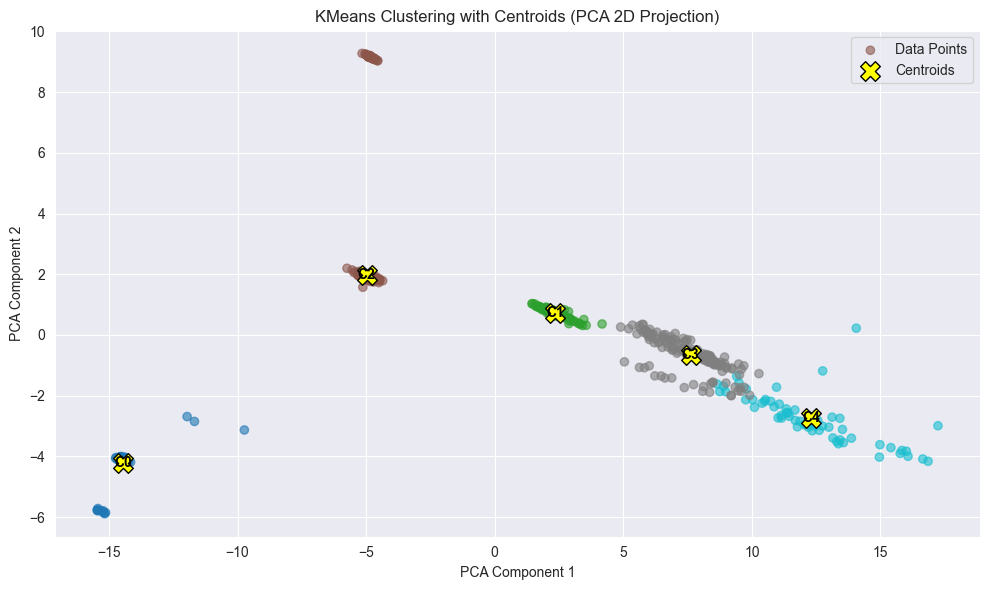

In [10]:

# Assuming flex_vectors and labels are already defined
X = np.array(flex_vectors)
y = np.array(labels)

print("Splitting benign and attack samples...")
X_benign = X[y == "benign"]
X_attack = X[y == "attack"]
X_attack = rd.choices(X_attack, k=50)
y_attack = ["attack"] * 50

X = np.concatenate([X_benign, X_attack], axis=0)
y = ["benign"] * 500 + ["attack"] * 50
print("Standardizing feature vectors...")
scaler = StandardScaler()
X_benign_scaled = scaler.fit_transform(X_benign)
X_all_scaled = scaler.transform(X)

print("Training KMeans on benign samples...")
kmeans = KMeans(n_clusters=5, random_state=42)
kmeans.fit(X_benign_scaled)

def min_distance(x):
    return np.min(np.linalg.norm(kmeans.cluster_centers_ - x, axis=1))

print("Computing anomaly threshold...")
benign_dists = [min_distance(x) for x in tqdm(X_benign_scaled, desc="Benign distances")]
threshold = np.percentile(benign_dists, 98.5)

print("Predicting anomalies...")
all_labels = [1 if cls == "attack" else 0 for cls in y]
pred_labels = [1 if min_distance(x) > threshold else 0 for x in tqdm(X_all_scaled, desc="Predicting")]

print("Evaluating...")
report = classification_report(all_labels, pred_labels, target_names=["Benign", "Attack"], output_dict=True)
df_report = pd.DataFrame(report).transpose()

# Plot precision, recall, f1-score
plot_data = df_report.loc[["Benign", "Attack"], ["precision", "recall", "f1-score"]]
ax = plot_data.plot(kind="bar", figsize=(10, 6), colormap='viridis', edgecolor='white')
plt.title("Precision, Recall, F1-score by Class")
plt.xticks(rotation=0)
plt.ylabel("Score")
plt.ylim(0, 1.05)
plt.grid(True, axis='y', linestyle='--', alpha=0.6)
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

# Plot confusion matrix
cm = confusion_matrix(all_labels, pred_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Benign", "Attack"], yticklabels=["Benign", "Attack"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

# Save models
model_path = "kmeans_model.joblib"
scaler_path = "scaler.joblib"
joblib.dump(kmeans, model_path)
joblib.dump(scaler, scaler_path)

print("\n=== Classification Report (Anomaly Detection) ===")
print(report)

# Reduce to 2D using PCA for visualization
pca = PCA(n_components=2)
X_2d = pca.fit_transform(X_all_scaled)
centroids_2d = pca.transform(kmeans.cluster_centers_)

# Predict cluster labels for visualization
cluster_labels = kmeans.predict(X_all_scaled)

# Plot clusters with centroids
plt.figure(figsize=(10, 6))
scatter = plt.scatter(X_2d[:, 0], X_2d[:, 1], c=cluster_labels, cmap="tab10", alpha=0.6, label="Data Points")
plt.scatter(centroids_2d[:, 0], centroids_2d[:, 1], c='yellow', marker='X', s=200, edgecolor='black', label="Centroids")

# Annotate centroids
for i, (x, y) in enumerate(centroids_2d):
    plt.text(x, y, f'C{i}', fontsize=10, ha='center', va='center', weight='bold', color='black')

plt.title("KMeans Clustering with Centroids (PCA 2D Projection)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()